In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import glob
from imutils import contours
import imutils
from imutils import perspective
from scipy.spatial import distance as dist
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist

In [46]:
def read_img(filename):
    '''
        Read BGR image from directory filename 
        Args:
            filename(str): directory of the image
        Returns:
            img(ndarray): image in RGB
    '''
    #read image
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [47]:
def seg_hsv(img):
    '''
        Return segmented image by red hue from RGB image
        Args: 
            img(ndarray): RGB image
        Returns:
            img(ndarray): HSV image, segmented by red hue
    '''
    # segmentation by red pixels
    # convert the image from RGB to HSV channels
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    
    # mask for lower range
    lower_red = np.array([0,120,70])
    upper_red = np.array([10,255,255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)


    # mask for upper range
    lower_red = np.array([170,120,70])
    upper_red = np.array([180,255,255])
    mask2 = cv2.inRange(hsv,lower_red,upper_red)


    # Generating the final mask to detect red color
    mask3 = mask1+mask2
    # overlay combined mask onto original rgb image, return bright red pixels only
    seg = cv2.bitwise_and(img,img,mask=mask3)
    return seg

In [128]:
def find_contours(seg):
    '''
        Return contours from segmented image in HSV
        Args:
            seg(ndarray): Segmented image in HSV
        Returns:
            cnts(ndarray(ndarray),ndim(-1,2)): Contours of segmented
    '''
    gray = cv2.cvtColor(seg, cv2.COLOR_RGB2GRAY)
    edged = cv2.Canny(gray, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # get contour set with largest contour area
    
    areas = []
    for cnt in cnts:
        areas.append(cv2.contourArea(cnt))
    cnt = cnts[np.argmax(areas)]
    
    # change dimension of contours into (-1,2)
    cnt = cnt.reshape(-1,2)
    return cnt

In [65]:
def cnts_max_dist(points):
    '''
       Return maximum length and two vertices from contours
       Args:
           points(ndarray,ndim=(-1,2)): Contours of segmented image
       Returns:
           length(np.float64): maximum length between two points in the contours
           point1(tuple(int,int)): one vertex coordinates
           point2(tuple(int,int)): another vertex coordinates
    '''

    hull = ConvexHull(points)

    # Extract the points forming the hull
    hullpoints = points[hull.vertices,:]

    # Naive way of finding the best pair in O(H^2) time if H is number of points on
    # hull
    hdist = cdist(hullpoints, hullpoints, metric='euclidean')

    # Get the farthest apart points
    bestpair = np.unravel_index(hdist.argmax(), hdist.shape)

    point1 = tuple(hullpoints[bestpair[0]])
    point2 = tuple(hullpoints[bestpair[1]])
    length = cdist(hullpoints[bestpair[0]].reshape(1,2),hullpoints[bestpair[1]].reshape(1,2),metric='euclidean')
    length = length[0][0]
    
    return length, point1, point2

In [72]:
def visualize_len(orig,length,point1,point2,viz=False):
    '''
        Visualize length of red patch on original image, in RGB
        Args:
            orig(ndarray): original image
            length(np.float64): length of red patch
            point1(tuple(int,int)): coordinates of one vertex
            point2(tuple(int,int)): coordinates of another vertex
            viz(bool, optional): visualization flag
    '''
    len_orig = orig.copy()
    cv2.circle(len_orig,point1,20,(0,255,0),-1)
    cv2.circle(len_orig,point2,20,(0,255,0),-1)
    cv2.line(len_orig,point1,point2,(0,255,0),10,-1)
    midptX = int((point1[0]+point2[0])/2)
    midptY = int((point1[1]+point2[1])/2)
    cv2.putText(len_orig, f"{length:.1f} px",
        (midptX + 15, midptY), cv2.FONT_HERSHEY_SIMPLEX,
        3, (0,255,0), 4)
    if viz:
        plt.figure(figsize=(20,12))
        plt.imshow(len_orig)
    return len_orig

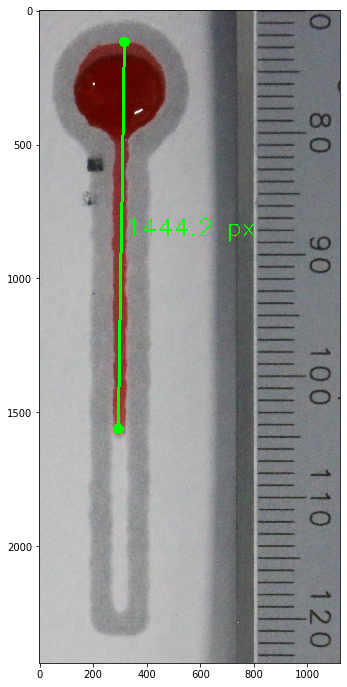

In [132]:
filename = glob.glob('./*.jpg')[20]
img = read_img(filename)
seg = seg_hsv(img)
cnts = find_contours(seg)
length,point1,point2 = cnts_max_dist(cnts)
result_img = visualize_len(img, length, point1,point2,viz=True)

In [120]:
def results(filename,viz=False):
    img = read_img(filename)
    seg = seg_hsv(img)
    cnts = find_contours(seg)
    length,point1,point2 = cnts_max_dist(cnts)
    final_img = visualize_len(img, length, point1,point2,viz)
    return final_img
# print(filename)

# Trial

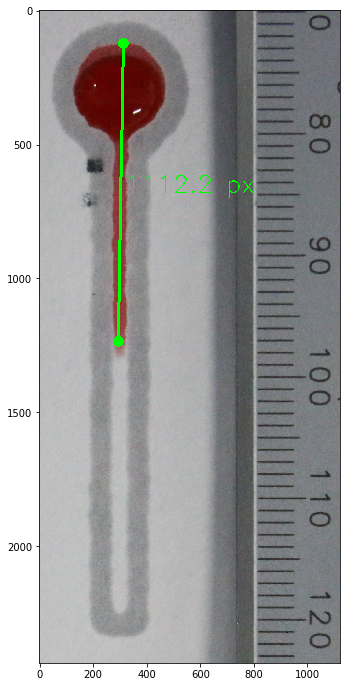

In [119]:
filename = glob.glob('./*.jpg')[7]
img = results(filename,viz=True)

In [109]:
images = []
for filename in glob.glob('./*.jpg'):
    len_img = results(filename)
    images.append(len_img)

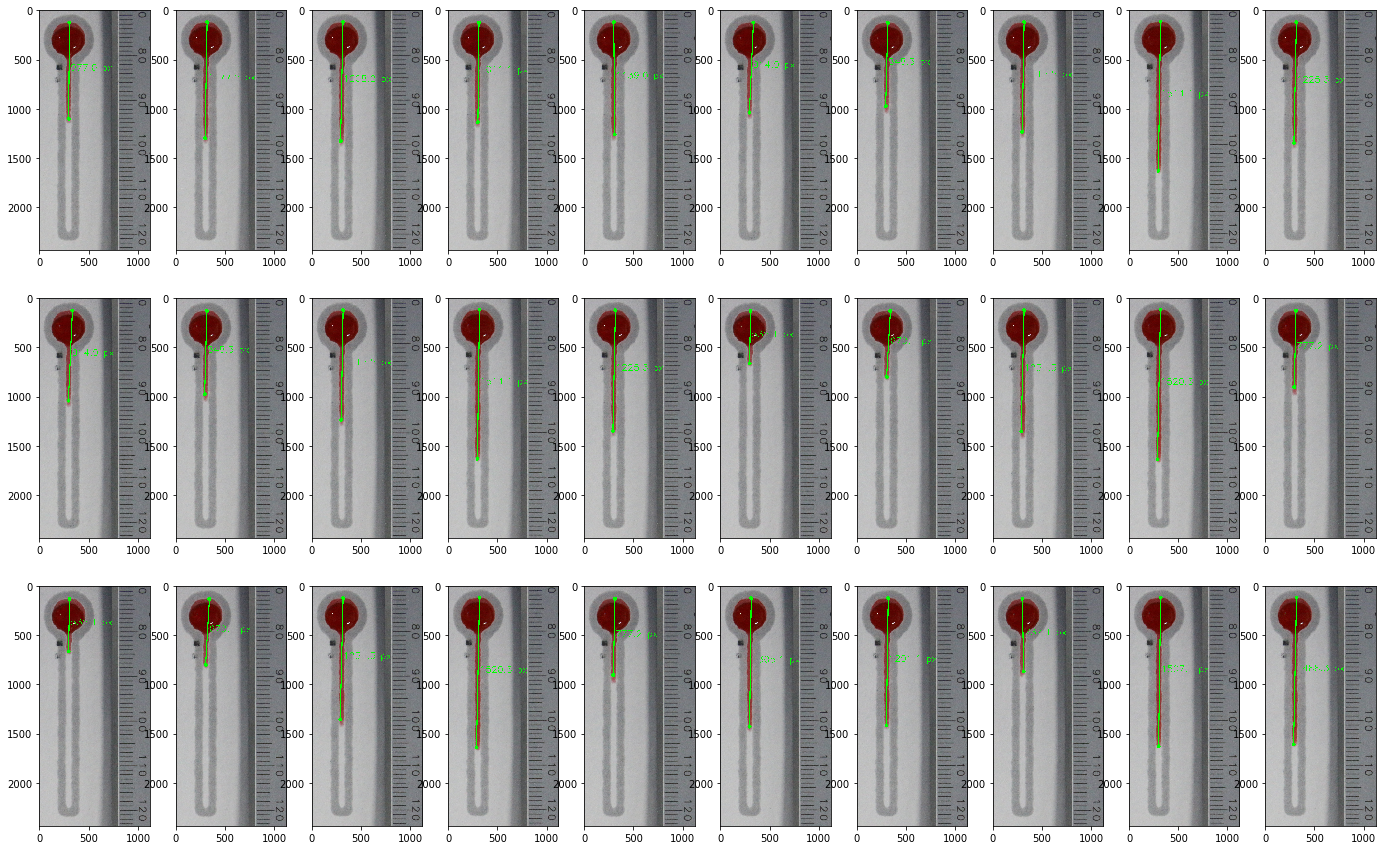

In [118]:
fig,axs = plt.subplots(3,10,figsize=(24,15))
for i in range(3):
    for j in range(10):
        axs[i,j].imshow(images[i*5+j])